In [138]:
import numpy as np
import random

class GridWorld:
    # call to initialize grid world enviroment, default will be a 5x5 grid with a start point at the top left corner and goal at
    # the bottom right corner, no obsticals, if probablity of obsticals is given, these will be placed in enviroment randomly
    def __init__(self, grid_size=(5, 5), start_point=(0, 0), goal_point=None, prob_obstacle=0):
        self.grid_size = grid_size
        self.start_point = start_point
        self.goal_point = goal_point if goal_point is not None else (grid_size[0] - 1, grid_size[1] - 1)
        self.prob_obstacle = prob_obstacle

        self.action_map = ['up', 'down', 'left', 'right']
        self.grid = np.zeros(self.grid_size, dtype=int)
        self._generate_obstacles()
        self.reset()


    # obstacles created based on probability argument passed
    # idealy a small number (> .8) is passed so path to goal is still achivable
    def _generate_obstacles(self):
        self.grid = np.zeros(self.grid_size, dtype=int)
        for r in range(self.grid_size[0]):
            for c in range(self.grid_size[1]):
                if random.random() < self.prob_obstacle and (r, c) != self.start_point and (r, c) != self.goal_point:
                    self.grid[r, c] = 1

    def reset(self):
        self.agent_point = self.start_point

        return self.agent_point

    def step(self, action_idx):
        action = self.action_map[action_idx]
        x, y = self.agent_point
        next_x, next_y = x, y

        if action == 'up' and x > 0:
            next_x -= 1
        elif action == 'down' and x < self.grid_size[0] - 1:
            next_x += 1
        elif action == 'left' and y > 0:
            next_y -= 1
        elif action == 'right' and y < self.grid_size[1] - 1:
            next_y += 1

        is_obstacle = self.grid[next_x, next_y] == 1

        if is_obstacle:                              # Penalty applied if agent bumps into obstacle
            next_x, next_y = x, y
            reward = -5
            done = False
        else:
            self.agent_point = (next_x, next_y)     # For non obstacle states, reward ig goal, otherwise penalize
            done = self.is_at_goal()
            reward = 1000 if done else -1

        return self.agent_point, reward, done, {}

    def is_at_goal(self):
        return self.agent_point == self.goal_point

    # For debugging
    def display_env(self):
        world = np.array(self.grid, dtype=object)
        x, y = self.agent_point
        gx, gy = self.goal_point
        world[x, y] = 'A'          # Agent
        world[gx, gy] = 'G'        # Goal
        print(world)

In [139]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Network for DQ Agent
class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [140]:
class DQNAgent:
    def __init__(self, grid_size, action_size=4, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, lr=1e-4, batch_size=64, memory_size=50000):
        self.grid_size = grid_size                # Size of the grid (grid_size x grid_size)
        self.state_size = 2                       # Size of state size (x, y)
        self.action_size = action_size            # Size of the action space (default 4: up, right, down, left)
        self.gamma = gamma                        # Discount factor
        self.epsilon = epsilon                    # Initial exploration rate
        self.epsilon_min = epsilon_min            # Minimum exploration rate, allows for agent to continue exploring
        self.epsilon_decay = epsilon_decay        # Decay rate for exploration
        self.batch_size = batch_size

        self.memory = deque(maxlen=memory_size)

        self.model = DQNetwork(self.state_size, action_size)
        self.target_model = DQNetwork(self.state_size, self.action_size)  # Target network
        self.target_model.load_state_dict(self.model.state_dict())  # Initialize target model with the same weights

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def update(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_target_network(self):
        # Update the target network weights from the Q-network
        self.target_model.load_state_dict(self.model.state_dict())

    def get_action(self, state, training=True):
        # Get the current state, determine if exploration or exploitation
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)

        # Predict Q values
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        # Convert to PyTorch tensors for quicker computation
        states = torch.FloatTensor(states)                       # Shape: [batch, state_dim]
        actions = torch.LongTensor(actions).unsqueeze(1)         # Shape: [batch, 1]
        rewards = torch.FloatTensor(rewards).unsqueeze(1)        # Shape: [batch, 1]
        next_states = torch.FloatTensor(next_states)             # Shape: [batch, state_dim]
        dones = torch.FloatTensor(dones).unsqueeze(1)            # Shape: [batch, 1]

        # Predict Q(s,a) using current model
        q_values = self.model(states).gather(1, actions)

        # Predict max Q(s',a') for next state using target model
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0].unsqueeze(1)

        # Compute target Q-values
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss
        loss = self.criterion(q_values, targets)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [141]:
def train_dqn(env, agent, episodes=500, max_steps=100, log_interval=100):
    rewards = []
    steps_list = []
    start_time = time.time()
    total_reward_accumulated = 0

    for episode in range(episodes):
        state = np.array(env.reset())
        total_reward = 0

        for step in range(max_steps):
            action = agent.get_action(state)                         # Get action
            next_state, reward, done, _ = env.step(action)           # Take step
            #reward = np.clip(reward, -1, 1)                          # clip reward
            next_state = np.array(next_state)
            agent.update(state, action, reward, next_state, done)    # Update state

            # Update state and total reward
            state = next_state
            total_reward += reward

            if done:
                break

        agent.replay()
        rewards.append(total_reward)
        total_reward_accumulated += total_reward
        steps_list.append(step + 1)

        # Decay exploration rate
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay

        # Update target network every 10 episodes
        if episode % 10 == 0:
            agent.update_target_network()

        if episode % log_interval == 0:
            avg_reward = np.mean(rewards[-log_interval:])
            avg_steps = np.mean(steps_list[-log_interval:])
            print(f"Episode {episode}/{episodes} | Avg Reward: {avg_reward:.2f} | Avg Steps: {avg_steps:.2f} | Epsilon: {agent.epsilon:.4f}")


    print(f"\nTraining completed in {time.time() - start_time:.2f} seconds.")
    print(f"\nTotal Reward Accumulated: {total_reward_accumulated}.")
    return rewards

In [142]:
def evaluate_dqn(env, agent, episodes=10, max_steps=100):
    rewards = []
    success_count = 0

    for ep in range(episodes):
        state = np.array(env.reset())
        total_reward = 0
        done = False

        for step in range(max_steps):
            action = agent.get_action(state, training=False)  # Use greedy policy
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = np.array(next_state)

            if done:
                if reward > 0:  # Assuming reaching goal gives +10
                    success_count += 1
                break

        rewards.append(total_reward)
        print(f"Episode {ep + 1}/{episodes} | Reward: {total_reward:.2f} | Steps: {step + 1}")

    avg_reward = np.mean(rewards)
    success_rate = success_count / episodes

    print(f"\nEvaluation over {episodes} episodes - Average Reward: {avg_reward:.2f} | Success Rate: {success_rate * 100:.2f}%")

    return rewards

In [211]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_reward_rate(rewards):
    # Plot Average Reward per Episode
    '''plt.plot(rewards)
    plt.title('Average Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')'''

    window = 100
    moving_avg = [np.mean(rewards[i:i+window]) for i in range(len(rewards)-window)]
    plt.plot(moving_avg)
    plt.title('Moving Average Reward (Per 100 Episodes)')


In [202]:
env = GridWorld(grid_size=(5,5), prob_obstacle=0.2)

env.display_env()

[['A' 0 0 0 0]
 [0 1 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 'G']]


In [203]:
agent = DQNAgent(grid_size=(5,5), gamma=.99, epsilon=1.0, epsilon_min=0.001, epsilon_decay=0.99)
rewards = train_dqn(env, agent, episodes=2000, max_steps=25, log_interval=100)

Episode 0/2000 | Avg Reward: -33.00 | Avg Steps: 25.00 | Epsilon: 0.9900
Episode 100/2000 | Avg Reward: 135.76 | Avg Steps: 24.06 | Epsilon: 0.3624
Episode 200/2000 | Avg Reward: 428.30 | Avg Steps: 21.42 | Epsilon: 0.1326
Episode 300/2000 | Avg Reward: 398.36 | Avg Steps: 20.63 | Epsilon: 0.0486
Episode 400/2000 | Avg Reward: 369.21 | Avg Steps: 19.11 | Epsilon: 0.0178
Episode 500/2000 | Avg Reward: 168.60 | Avg Steps: 21.86 | Epsilon: 0.0065
Episode 600/2000 | Avg Reward: 380.52 | Avg Steps: 20.94 | Epsilon: 0.0024
Episode 700/2000 | Avg Reward: 404.01 | Avg Steps: 20.11 | Epsilon: 0.0010
Episode 800/2000 | Avg Reward: 337.87 | Avg Steps: 20.95 | Epsilon: 0.0010
Episode 900/2000 | Avg Reward: 345.36 | Avg Steps: 21.47 | Epsilon: 0.0010
Episode 1000/2000 | Avg Reward: 477.52 | Avg Steps: 19.63 | Epsilon: 0.0010
Episode 1100/2000 | Avg Reward: 510.50 | Avg Steps: 19.24 | Epsilon: 0.0010
Episode 1200/2000 | Avg Reward: 752.33 | Avg Steps: 15.71 | Epsilon: 0.0010
Episode 1300/2000 | Avg 

Episode 1/10 | Reward: 965.00 | Steps: 16
Episode 2/10 | Reward: 993.00 | Steps: 8
Episode 3/10 | Reward: 971.00 | Steps: 14
Episode 4/10 | Reward: -488.00 | Steps: 100
Episode 5/10 | Reward: 987.00 | Steps: 10
Episode 6/10 | Reward: -488.00 | Steps: 100
Episode 7/10 | Reward: 968.00 | Steps: 13
Episode 8/10 | Reward: -488.00 | Steps: 100
Episode 9/10 | Reward: 968.00 | Steps: 13
Episode 10/10 | Reward: 976.00 | Steps: 13

Evaluation over 10 episodes - Average Reward: 536.40 | Success Rate: 70.00%


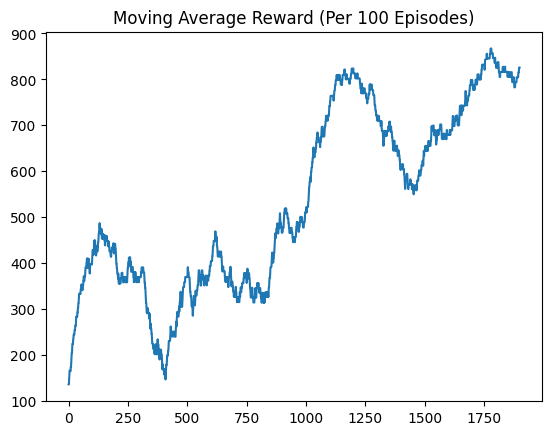

In [204]:
r = evaluate_dqn(env, agent)
plot_reward_rate(rewards)

In [216]:
env = GridWorld(grid_size=(15,15), prob_obstacle=0.1)
env.display_env()

[['A' 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 1 0 0 1 0 1 0 0 0 0 'G']]


In [226]:
large_space_agent = DQNAgent(grid_size=(15,15), gamma=.97, epsilon=1.0, epsilon_min=0.001, epsilon_decay=0.995)

rewards = train_dqn(env, large_space_agent, episodes=1000, max_steps=200, log_interval=100)

Episode 0/1000 | Avg Reward: -232.00 | Avg Steps: 200.00 | Epsilon: 0.9950
Episode 100/1000 | Avg Reward: 4.82 | Avg Steps: 186.04 | Epsilon: 0.6027
Episode 200/1000 | Avg Reward: 162.28 | Avg Steps: 169.02 | Epsilon: 0.3651
Episode 300/1000 | Avg Reward: 700.20 | Avg Steps: 95.89 | Epsilon: 0.2212
Episode 400/1000 | Avg Reward: 932.54 | Avg Steps: 50.46 | Epsilon: 0.1340
Episode 500/1000 | Avg Reward: 857.04 | Avg Steps: 59.05 | Epsilon: 0.0812
Episode 600/1000 | Avg Reward: 872.39 | Avg Steps: 54.23 | Epsilon: 0.0492
Episode 700/1000 | Avg Reward: 747.94 | Avg Steps: 69.47 | Epsilon: 0.0298
Episode 800/1000 | Avg Reward: 838.96 | Avg Steps: 52.27 | Epsilon: 0.0180
Episode 900/1000 | Avg Reward: 947.97 | Avg Steps: 36.15 | Epsilon: 0.0109

Training completed in 17.35 seconds.

Total Reward Accumulated: 700571.


Episode 1/10 | Reward: 963.00 | Steps: 34
Episode 2/10 | Reward: 954.00 | Steps: 43
Episode 3/10 | Reward: 926.00 | Steps: 47
Episode 4/10 | Reward: 962.00 | Steps: 31
Episode 5/10 | Reward: 957.00 | Steps: 36
Episode 6/10 | Reward: 962.00 | Steps: 35
Episode 7/10 | Reward: 937.00 | Steps: 36
Episode 8/10 | Reward: 958.00 | Steps: 39
Episode 9/10 | Reward: 943.00 | Steps: 34
Episode 10/10 | Reward: 956.00 | Steps: 37

Evaluation over 10 episodes - Average Reward: 951.80 | Success Rate: 100.00%


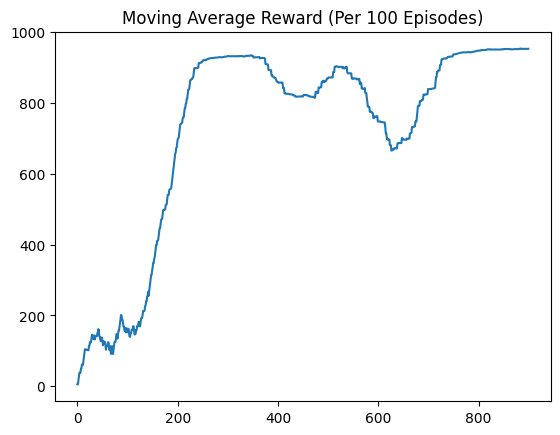

In [227]:
r = evaluate_dqn(env, large_space_agent)
plot_reward_rate(rewards)

In [174]:
env = GridWorld(grid_size=(30,30), prob_obstacle=0.1)
env.display_env()

[['A' 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0

In [198]:
large_space_agent = DQNAgent(grid_size=(30,30), gamma=.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995)

rewards = train_dqn(env, large_space_agent, episodes=1500, max_steps=900, log_interval=100)


Episode 0/1500 | Avg Reward: -1252.00 | Avg Steps: 900.00 | Epsilon: 0.9950
Episode 100/1500 | Avg Reward: -1157.74 | Avg Steps: 897.19 | Epsilon: 0.6027
Episode 200/1500 | Avg Reward: -1078.89 | Avg Steps: 887.97 | Epsilon: 0.3651
Episode 300/1500 | Avg Reward: -1030.80 | Avg Steps: 884.35 | Epsilon: 0.2212
Episode 400/1500 | Avg Reward: -995.09 | Avg Steps: 891.88 | Epsilon: 0.1340
Episode 500/1500 | Avg Reward: -249.72 | Avg Steps: 656.21 | Epsilon: 0.0812
Episode 600/1500 | Avg Reward: 565.32 | Avg Steps: 265.73 | Epsilon: 0.0492
Episode 700/1500 | Avg Reward: 605.02 | Avg Steps: 193.66 | Epsilon: 0.0298
Episode 800/1500 | Avg Reward: 475.84 | Avg Steps: 229.84 | Epsilon: 0.0180
Episode 900/1500 | Avg Reward: 66.17 | Avg Steps: 443.86 | Epsilon: 0.0109
Episode 1000/1500 | Avg Reward: -204.20 | Avg Steps: 479.82 | Epsilon: 0.0100
Episode 1100/1500 | Avg Reward: -709.51 | Avg Steps: 692.42 | Epsilon: 0.0100
Episode 1200/1500 | Avg Reward: 344.56 | Avg Steps: 315.19 | Epsilon: 0.0100


Episode 1/10 | Reward: 788.00 | Steps: 137
Episode 2/10 | Reward: 684.00 | Steps: 181
Episode 3/10 | Reward: 692.00 | Steps: 197
Episode 4/10 | Reward: 523.00 | Steps: 250
Episode 5/10 | Reward: 726.00 | Steps: 195
Episode 6/10 | Reward: 542.00 | Steps: 247
Episode 7/10 | Reward: 506.00 | Steps: 275
Episode 8/10 | Reward: 717.00 | Steps: 188
Episode 9/10 | Reward: 685.00 | Steps: 208
Episode 10/10 | Reward: 636.00 | Steps: 213

Evaluation over 10 episodes - Average Reward: 649.90 | Success Rate: 100.00%


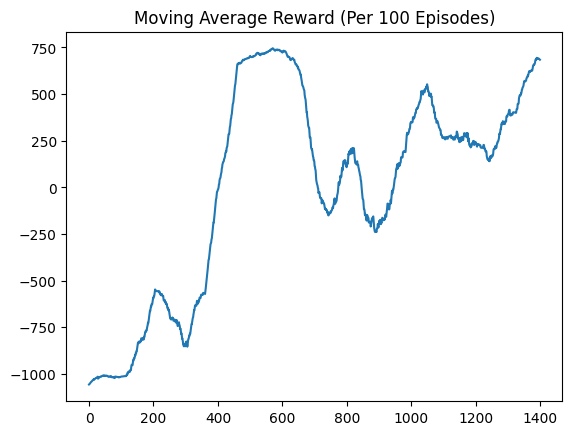

In [197]:
r = evaluate_dqn(env, large_space_agent, max_steps=900)
plot_reward_rate(rewards)